In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor


from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('./data_feature_eng.csv')

In [3]:
df.head()

,Unnamed: 0,ts,pickup_cluster,request_count,mins,hour,day,month,dayofweek,quarter
0,17568,2020-03-26 00:00:00,0,0.0,0,0,26,3,3,1
1,17569,2020-03-26 00:30:00,0,0.0,30,0,26,3,3,1
2,17570,2020-03-26 01:00:00,0,0.0,0,1,26,3,3,1
3,17571,2020-03-26 01:30:00,0,2.0,30,1,26,3,3,1
4,17572,2020-03-26 02:00:00,0,0.0,0,2,26,3,3,1


In [4]:
df.drop(columns=['Unnamed: 0'],inplace=True)
df = df[['ts','pickup_cluster','mins','hour','month','quarter','dayofweek','request_count']]

In [5]:
df.head()

,ts,pickup_cluster,mins,hour,month,quarter,dayofweek,request_count
0,2020-03-26 00:00:00,0,0,0,3,1,3,0.0
1,2020-03-26 00:30:00,0,30,0,3,1,3,0.0
2,2020-03-26 01:00:00,0,0,1,3,1,3,0.0
3,2020-03-26 01:30:00,0,30,1,3,1,3,2.0
4,2020-03-26 02:00:00,0,0,2,3,1,3,0.0


In [6]:
df['ts'] = pd.to_datetime(df['ts'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878400 entries, 0 to 878399
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   ts              878400 non-null  datetime64[ns]
 1   pickup_cluster  878400 non-null  int64         
 2   mins            878400 non-null  int64         
 3   hour            878400 non-null  int64         
 4   month           878400 non-null  int64         
 5   quarter         878400 non-null  int64         
 6   dayofweek       878400 non-null  int64         
 7   request_count   878400 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 53.6 MB


In [8]:
train = df[df.ts.dt.day <=23]
test = df[df.ts.dt.day > 23]

In [9]:
train.shape

(662400, 8)

In [10]:
test.shape

(216000, 8)

In [11]:
X_train = train.iloc[:,1:-1]
y_train = train.iloc[:,-1]

X_test = test.iloc[:,1:-1]
y_test = test.iloc[:,-1]

In [12]:
X_train

,pickup_cluster,mins,hour,month,quarter,dayofweek
288,0,0,0,4,2,2
289,0,30,0,4,2,2
290,0,0,1,4,2,2
291,0,30,1,4,2,2
292,0,0,2,4,2,2
...,...,...,...,...,...,...
878251,49,30,21,3,1,1
878252,49,0,22,3,1,1
878253,49,30,22,3,1,1
878254,49,0,23,3,1,1


In [13]:
y_train

288        0.0
289        0.0
290        0.0
291        0.0
292        0.0
          ... 
878251     9.0
878252    11.0
878253     2.0
878254     3.0
878255     6.0
Name: request_count, Length: 662400, dtype: float64

## Random Forest Feature Importance

In [33]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest regressor on label encoded data
rf_label = RandomForestRegressor(n_estimators=100, random_state=42,n_jobs = -1)
rf_label.fit(X_train, y_train)



RandomForestRegressor(n_jobs=-1, random_state=42)

In [34]:
# Extract feature importance scores for label encoded data
fi_df2 = pd.DataFrame({
    'feature': X_train.columns,
    'rf_importance': rf_label.feature_importances_
}).sort_values(by='rf_importance', ascending=False)

fi_df2

,feature,rf_importance
0,pickup_cluster,0.429983
2,hour,0.264971
3,month,0.126651
4,quarter,0.082007
5,dayofweek,0.080509
1,mins,0.015879


## Gradient Boosting Feature Importance

In [36]:
from sklearn.ensemble import GradientBoostingRegressor

# Train a Random Forest regressor on label encoded data
gb_label = GradientBoostingRegressor()
gb_label.fit(X_train, y_train)

# Extract feature importance scores for label encoded data
fi_df3 = pd.DataFrame({
    'feature': X_train.columns,
    'gb_importance': gb_label.feature_importances_
}).sort_values(by='gb_importance', ascending=False)

fi_df3

,feature,gb_importance
2,hour,0.344024
0,pickup_cluster,0.302501
3,month,0.225128
4,quarter,0.111583
5,dayofweek,0.015201
1,mins,0.001563


## Lasso Feature Importance


In [37]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Train a LASSO regression model
# We'll use a relatively small value for alpha (the regularization strength) for demonstration purposes
lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X_scaled, y_train)

# Extract coefficients
fi_df5 = pd.DataFrame({
    'feature': X_train.columns,
    'lasso_coeff': lasso.coef_
}).sort_values(by='lasso_coeff', ascending=False)

fi_df5


,feature,lasso_coeff
3,month,2.183593
2,hour,1.885763
0,pickup_cluster,0.564333
1,mins,-0.020916
5,dayofweek,-0.248296
4,quarter,-3.524165


In [42]:
f = fi_df2.merge(fi_df3,on='feature',how='inner').merge(fi_df5,on='feature',how='inner')

In [46]:
f

,feature,rf_importance,gb_importance,lasso_coeff
0,pickup_cluster,0.429983,0.302501,0.564333
1,hour,0.264971,0.344024,1.885763
2,month,0.126651,0.225128,2.183593
3,quarter,0.082007,0.111583,-3.524165
4,dayofweek,0.080509,0.015201,-0.248296
5,mins,0.015879,0.001563,-0.020916


In [48]:
f['mean'] = f.iloc[:,1:].sum(axis=1)/3

In [49]:
f.sort_values(by=['mean'],ascending=False)

,feature,rf_importance,gb_importance,lasso_coeff,mean
2,month,0.126651,0.225128,2.183593,0.845124
1,hour,0.264971,0.344024,1.885763,0.831586
0,pickup_cluster,0.429983,0.302501,0.564333,0.432273
5,mins,0.015879,0.001563,-0.020916,-0.001158
4,dayofweek,0.080509,0.015201,-0.248296,-0.050862
3,quarter,0.082007,0.111583,-3.524165,-1.110192


## Testing the feature selection

In [50]:
from sklearn.metrics import root_mean_squared_error
y_pred = rf_label.predict(X_test)
root_mean_squared_error(y_pred=y_pred,y_true=y_test)

4.348067658896941

In [51]:
##After feature selection
X_train_c = X_train.loc[:,['month','hour','pickup_cluster']]
X_test_c = X_test.loc[:,['month','hour','pickup_cluster']]

In [52]:
# Train a Random Forest regressor on label encoded data
rf_label = RandomForestRegressor(n_estimators=100, random_state=42,n_jobs = -1)
rf_label.fit(X_train_c, y_train)



y_pred = rf_label.predict(X_test_c)
root_mean_squared_error(y_pred=y_pred,y_true=y_test)

4.753229590589624

Its much worse ,after selection but train time is reduced

## Checking all models

In [69]:
def scorer(model_name, model):
    
    output = []
    
    output.append(model_name)
    # K-fold cross-validation
    # kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    # scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='rmse')
    
    #output.append(scores.mean())
    
    model.fit(X_train,y_train)
    
    y_pred = model.predict(X_test)
    
    output.append(root_mean_squared_error(y_test,y_pred))
    
    return output
    

In [70]:

model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [ ]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

model_df = pd.DataFrame(model_output, columns=['name','r2','rmse'])
model_df.sort_values(['rmse'])
model_df

## Including Lag

In [1]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

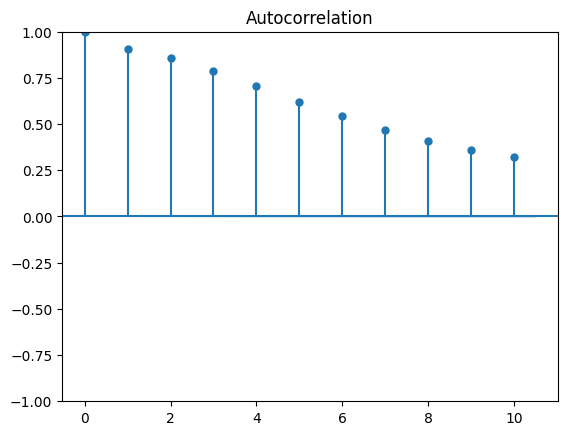

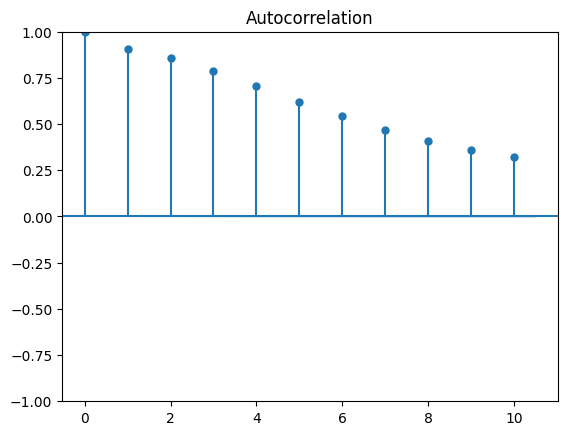

In [14]:
plot_acf(train['request_count'],lags=10)

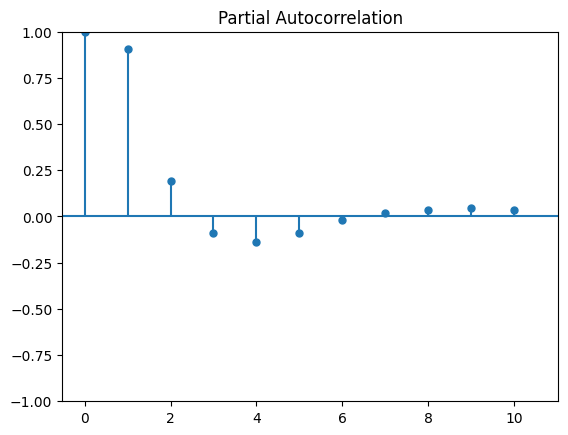

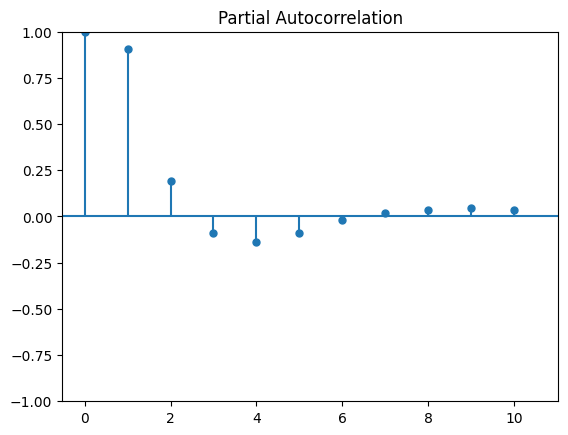

In [15]:
plot_pacf(train['request_count'],lags=10)

## From this we understand 
- ### t-3,t-2,t-1 is hightly correlated to t ,where t is request count

In [19]:
### Creating feature of this 
df


,ts,pickup_cluster,mins,hour,month,quarter,dayofweek,request_count
0,2020-03-26 00:00:00,0,0,0,3,1,3,0.0
1,2020-03-26 00:30:00,0,30,0,3,1,3,0.0
2,2020-03-26 01:00:00,0,0,1,3,1,3,0.0
3,2020-03-26 01:30:00,0,30,1,3,1,3,2.0
4,2020-03-26 02:00:00,0,0,2,3,1,3,0.0
...,...,...,...,...,...,...,...,...
878395,2021-03-26 21:30:00,49,30,21,3,1,4,5.0
878396,2021-03-26 22:00:00,49,0,22,3,1,4,2.0
878397,2021-03-26 22:30:00,49,30,22,3,1,4,2.0
878398,2021-03-26 23:00:00,49,0,23,3,1,4,5.0


In [14]:
df['lag_1'] = df.groupby('pickup_cluster')['request_count'].shift(1)
df['lag_2'] = df.groupby('pickup_cluster')['request_count'].shift(2)
df['lag_3'] = df.groupby('pickup_cluster')['request_count'].shift(3)

In [15]:
df

,ts,pickup_cluster,mins,hour,month,quarter,dayofweek,request_count,lag_1,lag_2,lag_3
0,2020-03-26 00:00:00,0,0,0,3,1,3,0.0,NaN,NaN,NaN
1,2020-03-26 00:30:00,0,30,0,3,1,3,0.0,0.0,NaN,NaN
2,2020-03-26 01:00:00,0,0,1,3,1,3,0.0,0.0,0.0,NaN
3,2020-03-26 01:30:00,0,30,1,3,1,3,2.0,0.0,0.0,0.0
4,2020-03-26 02:00:00,0,0,2,3,1,3,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
878395,2021-03-26 21:30:00,49,30,21,3,1,4,5.0,9.0,5.0,7.0
878396,2021-03-26 22:00:00,49,0,22,3,1,4,2.0,5.0,9.0,5.0
878397,2021-03-26 22:30:00,49,30,22,3,1,4,2.0,2.0,5.0,9.0
878398,2021-03-26 23:00:00,49,0,23,3,1,4,5.0,2.0,2.0,5.0


In [16]:
df.dropna(inplace=True)

In [17]:
df

,ts,pickup_cluster,mins,hour,month,quarter,dayofweek,request_count,lag_1,lag_2,lag_3
3,2020-03-26 01:30:00,0,30,1,3,1,3,2.0,0.0,0.0,0.0
4,2020-03-26 02:00:00,0,0,2,3,1,3,0.0,2.0,0.0,0.0
5,2020-03-26 02:30:00,0,30,2,3,1,3,0.0,0.0,2.0,0.0
6,2020-03-26 03:00:00,0,0,3,3,1,3,0.0,0.0,0.0,2.0
7,2020-03-26 03:30:00,0,30,3,3,1,3,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
878395,2021-03-26 21:30:00,49,30,21,3,1,4,5.0,9.0,5.0,7.0
878396,2021-03-26 22:00:00,49,0,22,3,1,4,2.0,5.0,9.0,5.0
878397,2021-03-26 22:30:00,49,30,22,3,1,4,2.0,2.0,5.0,9.0
878398,2021-03-26 23:00:00,49,0,23,3,1,4,5.0,2.0,2.0,5.0


In [18]:
train = df[df.ts.dt.day <=23]
test = df[df.ts.dt.day > 23]

X_train = train.iloc[:,1:-1]
y_train = train.iloc[:,-1]

X_test = test.iloc[:,1:-1]
y_test = test.iloc[:,-1]

In [32]:
# Train a Random Forest regressor on label encoded data
rf_label = RandomForestRegressor(n_estimators=100, random_state=42,n_jobs = -1)
rf_label.fit(X_train, y_train)




RandomForestRegressor(n_jobs=-1, random_state=42)

In [30]:
rf_label

RandomForestRegressor(n_jobs=-1, random_state=42)

In [31]:
from sklearn.metrics import root_mean_squared_error
y_pred = rf_label.predict(X_test)
root_mean_squared_error(y_pred=y_pred,y_true=y_test)

2.5857690401871665

## Moving to Xgboost Algorithm

In [19]:
import xgboost as xgb

In [20]:
model=xgb.XGBRegressor(learning_rate=0.01, random_state=0, n_estimators=600, max_depth=8, objective="reg:squarederror")

In [21]:
eval_set = [(X_test, y_test)]
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [23]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)
r2_score(y_pred=y_pred,y_true=y_test)

0.881426354255553

In [41]:
y_pred = model.predict(X_test)
root_mean_squared_error(y_pred=y_pred,y_true=y_test)

2.492300552972501

### Xgboost perform better then RandomForest

In [39]:
##Final
X = df.loc[:,['pickup_cluster', 'mins', 'hour', 'month', 'quarter', 'dayofweek', 'lag_1', 'lag_2', 'lag_3']]
y = df['request_count']

In [40]:
model=xgb.XGBRegressor(learning_rate=0.01, random_state=0, n_estimators=600, max_depth=8, objective="reg:squarederror")
model.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [41]:
import pickle
with open('model.pkl','wb') as f:
    pickle.dump(model,f)

In [42]:
df

,ts,pickup_cluster,mins,hour,month,quarter,dayofweek,request_count,lag_1,lag_2,lag_3
3,2020-03-26 01:30:00,0,30,1,3,1,3,2.0,0.0,0.0,0.0
4,2020-03-26 02:00:00,0,0,2,3,1,3,0.0,2.0,0.0,0.0
5,2020-03-26 02:30:00,0,30,2,3,1,3,0.0,0.0,2.0,0.0
6,2020-03-26 03:00:00,0,0,3,3,1,3,0.0,0.0,0.0,2.0
7,2020-03-26 03:30:00,0,30,3,3,1,3,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
878395,2021-03-26 21:30:00,49,30,21,3,1,4,5.0,9.0,5.0,7.0
878396,2021-03-26 22:00:00,49,0,22,3,1,4,2.0,5.0,9.0,5.0
878397,2021-03-26 22:30:00,49,30,22,3,1,4,2.0,2.0,5.0,9.0
878398,2021-03-26 23:00:00,49,0,23,3,1,4,5.0,2.0,2.0,5.0


In [1]:
###Testing ARIMA Model Here

In [45]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt


In [47]:
df.set_index('ts', inplace=True)

In [48]:
df

,pickup_cluster,mins,hour,month,quarter,dayofweek,request_count,lag_1,lag_2,lag_3
ts,,,,,,,,,,
2020-03-26 01:30:00,0,30,1,3,1,3,2.0,0.0,0.0,0.0
2020-03-26 02:00:00,0,0,2,3,1,3,0.0,2.0,0.0,0.0
2020-03-26 02:30:00,0,30,2,3,1,3,0.0,0.0,2.0,0.0
2020-03-26 03:00:00,0,0,3,3,1,3,0.0,0.0,0.0,2.0
2020-03-26 03:30:00,0,30,3,3,1,3,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-03-26 21:30:00,49,30,21,3,1,4,5.0,9.0,5.0,7.0
2021-03-26 22:00:00,49,0,22,3,1,4,2.0,5.0,9.0,5.0
2021-03-26 22:30:00,49,30,22,3,1,4,2.0,2.0,5.0,9.0


In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Value ({key}):', value)

test_stationarity(df['request_count'])


In [ ]:
df['request_count_diff'] = df['request_count'].diff().dropna()


In [54]:
p = 1  # AR order
d = 1  # Differencing order
q = 1  # MA order
df_subset = df.iloc[-10000:]  # Use the last 10,000 samples

model = ARIMA(df_subset['request_count'] ,order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())


C:\Users\himan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
C:\Users\himan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
C:\Users\himan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:          request_count   No. Observations:                10000
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -22233.022
Date:                Fri, 02 Aug 2024   AIC                          44472.044
Time:                        14:48:30   BIC                          44493.675
Sample:                    08-30-2020   HQIC                         44479.366
                         - 03-26-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1639      0.015    -10.907      0.000      -0.193      -0.134
ma.L1         -0.2524      0.015    -17.025      0.000      -0.281      -0.223
sigma2         4.9986      0.036    139.560      0.0

In [55]:
forecast = model_fit.forecast(steps=10)
print(forecast)


2021-03-27 00:00:00    2.375364
2021-03-27 00:30:00    2.149937
2021-03-27 01:00:00    2.186885
2021-03-27 01:30:00    2.180829
2021-03-27 02:00:00    2.181822
2021-03-27 02:30:00    2.181659
2021-03-27 03:00:00    2.181686
2021-03-27 03:30:00    2.181682
2021-03-27 04:00:00    2.181682
2021-03-27 04:30:00    2.181682
Freq: 30min, Name: predicted_mean, dtype: float64


In [57]:
from sklearn.metrics import root_mean_squared_error
import numpy as np

y_true = df['request_count'][-10:]
y_pred = forecast
rmse = np.sqrt(root_mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')


RMSE: 1.9579363644734435
